In [116]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
BASE_DIR = os.getenv("BASEDIR")

In [50]:
from datasetsforecast.m3 import M3

In [51]:
dfs = M3.load(directory=f"{BASE_DIR}/data", group="Monthly")[0]

/home/pranav-pc/projects/ts/.venv/lib/python3.12/site-packages/datasetsforecast/m3.py:108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [52]:
dfs[dfs.unique_id == "M1"]["y"]

0     2640.0
1     2640.0
2     2160.0
3     4200.0
4     3360.0
       ...  
63    3720.0
64    2160.0
65     480.0
66    2040.0
67    1440.0
Name: y, Length: 68, dtype: float64

In [53]:
from statsmodels.tsa.stattools import adfuller


def check_stationarity(time_series):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check if a time series is stationary.

    Parameters:
        time_series (pd.Series or list): The time series data to check for stationarity.

    Returns:
        str: Interpretation result (stationary or non-stationary).
        dict: Test results (ADF statistic, p-value, critical values).
    """
    # Convert the input data to a pandas Series if it's not already
    if not isinstance(time_series, pd.Series):
        time_series = pd.Series(time_series)

    # Perform the Augmented Dickey-Fuller test
    result = adfuller(time_series)

    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    # Interpretation based on p-value
    if p_value < 0.05:
        return "The time series is likely stationary (Reject Null Hypothesis).", pd.DataFrame(
            {
                "ADF Statistic": adf_statistic,
                "P-Value": p_value,
                "Critical Values": critical_values,
            }
        )
    else:
        return (
            "The time series is likely non-stationary (Fail to Reject Null Hypothesis).",
            pd.DataFrame(
                {
                    "ADF Statistic": adf_statistic,
                    "P-Value": p_value,
                    "Critical Values": critical_values,
                }
            ),
        )


check_stationarity(dfs[dfs.unique_id == "M1"]["y"])

('The time series is likely non-stationary (Fail to Reject Null Hypothesis).',
      ADF Statistic   P-Value  Critical Values
 1%       -1.758874  0.401062        -3.536928
 5%       -1.758874  0.401062        -2.907887
 10%      -1.758874  0.401062        -2.591493)

* If the ADF Statistic is more negative (lower value), it suggests stronger evidence against the null hypothesis that the time series is non-stationary.
* The idea is that if the ADF Statistic is lower (more negative) than the critical value at a given confidence level, you can reject the null hypothesis (i.e., the time series is stationary).
* If the ADF Statistic is higher than the critical value (less negative), you fail to reject the null hypothesis (i.e., the time series is non-stationary).

In [54]:
def adf_score(time_series: pd.Series):
    result = adfuller(time_series)
    return pd.Series({"stationary": bool(result[1] < 0.05), "adf_statistic": float(result[0])})


adf_score(dfs[dfs.unique_id == "M1"]["y"])

stationary          False
adf_statistic   -1.758874
dtype: object

In [55]:
dfs.unique_id.unique()

array(['M1', 'M10', 'M100', ..., 'M997', 'M998', 'M999'], dtype=object)

In [56]:
stationary_test = (
    dfs.groupby("unique_id")
    .apply(lambda ds: adf_score(ds["y"]))
    .reset_index()
    .sort_values("adf_statistic")
)
stationary_test.head()

/tmp/ipykernel_43818/757579063.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,unique_id,stationary,adf_statistic
136,M1120,True,-16.471151
570,M226,True,-11.703259
560,M217,True,-11.192177
426,M1382,True,-11.038399
421,M1378,True,-10.668515


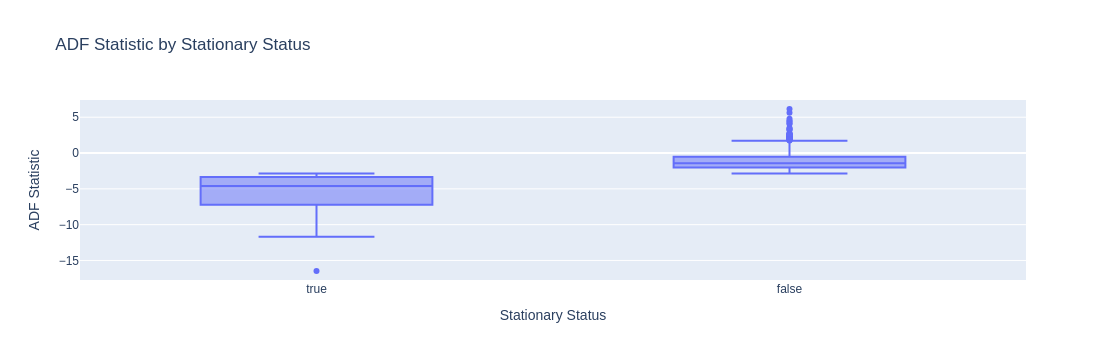

In [57]:
import plotly.express as px

fig = px.box(
    stationary_test,
    y="adf_statistic",
    x="stationary",
    title="ADF Statistic by Stationary Status",
    labels={"adf_statistic": "ADF Statistic", "stationary": "Stationary Status"},
)

fig.show()

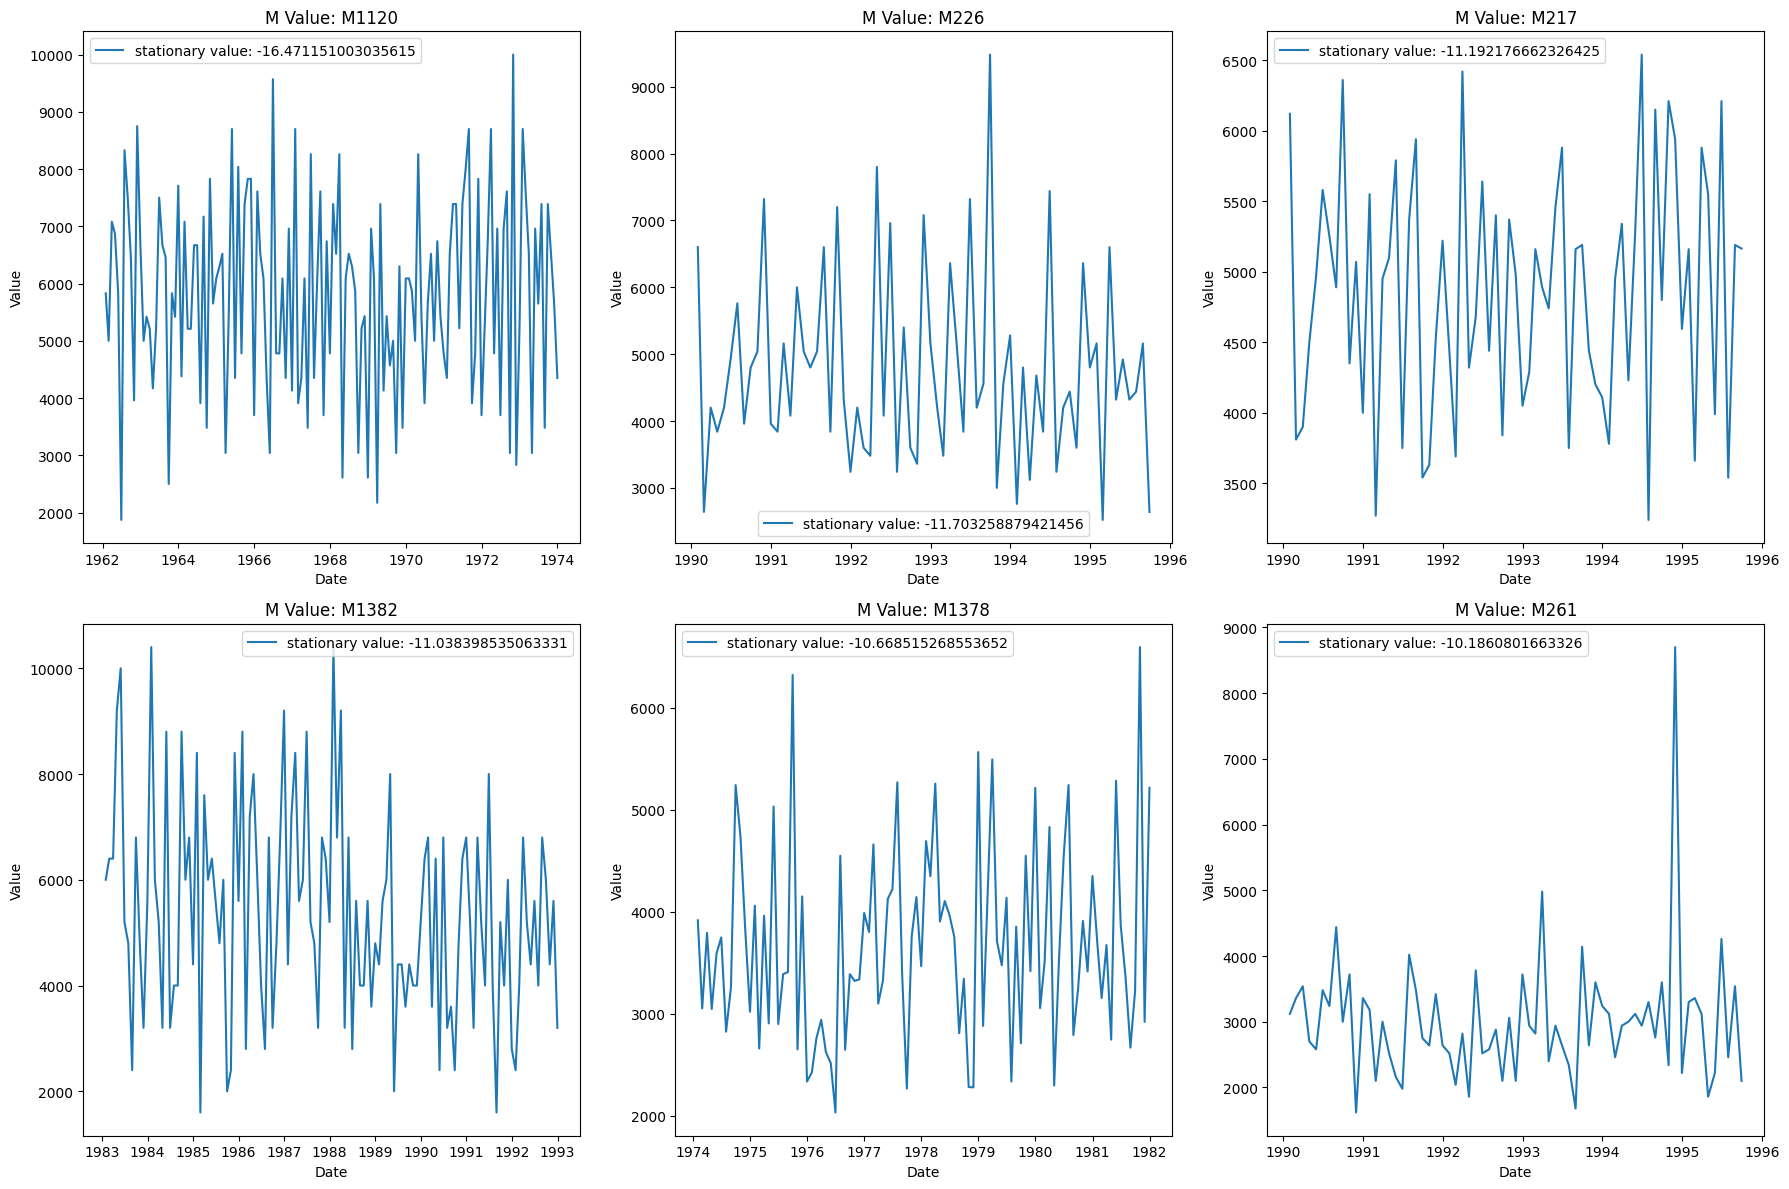

In [73]:
def plot_ts(series):
    # Create a figure for the subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns of plots

    # Flatten axes to iterate easily
    axes = axes.flatten()

    # Loop through M values and create a plot for each
    for i, data in enumerate(series):
        M, value = data
        ax = axes[i]
        subset = dfs[dfs["unique_id"] == M].set_index(
            "ds"
        )  # Filter the DataFrame for the current M value

        # Plot using matplotlib (or you can use Plotly as well)
        ax.plot(subset.index, subset["y"], label=f"stationary value: {value}")
        ax.set_title(f"M Value: {M}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# stationary ts
plot_ts(stationary_test[["unique_id", "adf_statistic"]].head(6).values)

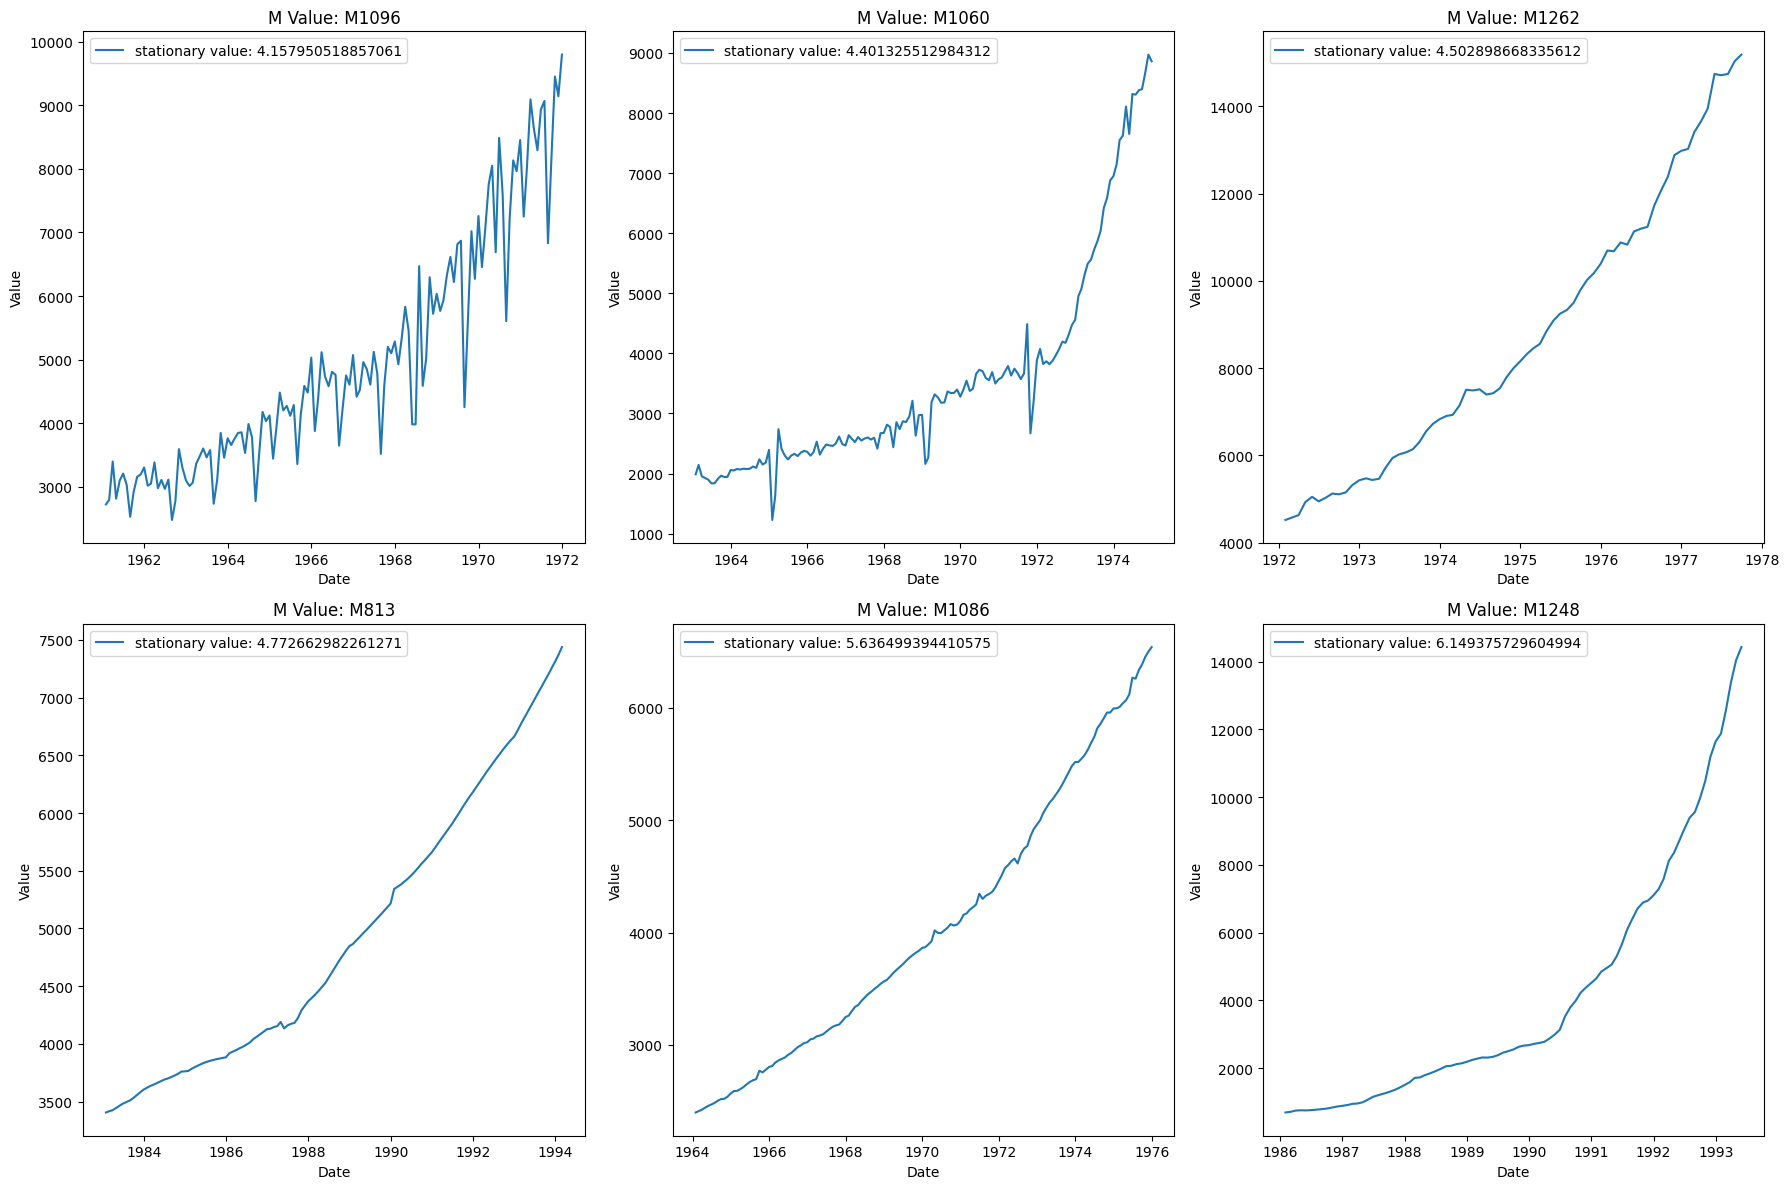

In [74]:
# non-stationary ts
plot_ts(stationary_test[["unique_id", "adf_statistic"]].tail(6).values)

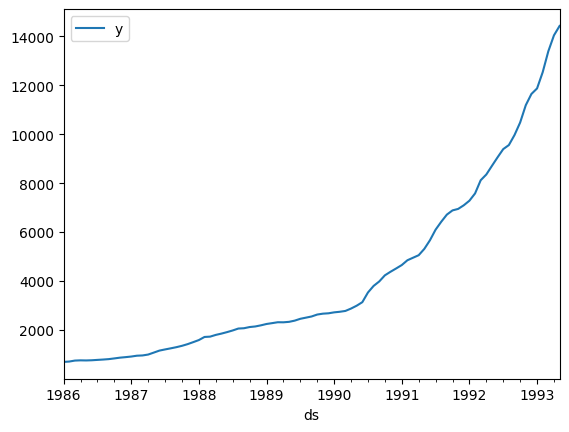

In [129]:
## Let's us make non stationary ts stationary again
# example non-stationary ts : M1248
ds = dfs[dfs.unique_id == "M1248"].drop("unique_id", axis=1).set_index("ds").sort_index()
ds.plot();

<Axes: xlabel='ds'>

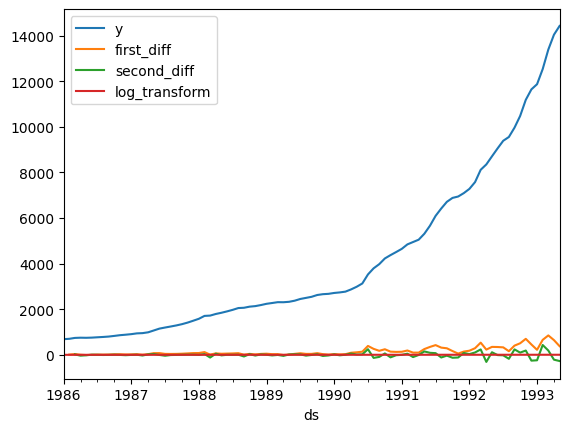

In [130]:
ds["first_diff"] = ds.diff()
ds["second_diff"] = ds.first_diff.diff()
ds["log_transform"] = np.log(ds["y"])

ds.plot()

<Axes: ylabel='Density'>

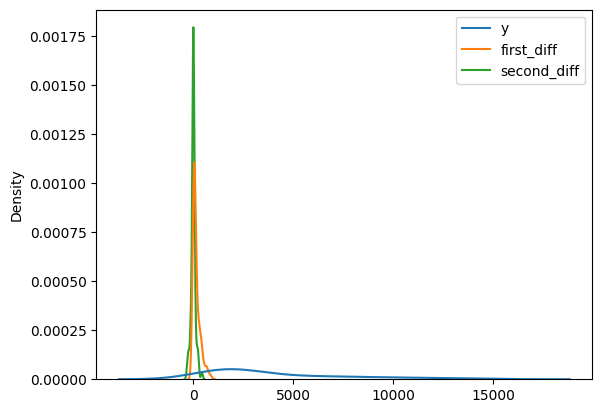

In [133]:
import seaborn as sns

sns.kdeplot(ds.drop("log_transform", axis=1))

In [111]:
check_stationarity(ds.y.dropna())

('The time series is likely non-stationary (Fail to Reject Null Hypothesis).',
      ADF Statistic  P-Value  Critical Values
 1%        6.149376      1.0        -3.508783
 5%        6.149376      1.0        -2.895784
 10%       6.149376      1.0        -2.585038)

In [112]:
check_stationarity(ds.first_diff.dropna())

('The time series is likely non-stationary (Fail to Reject Null Hypothesis).',
      ADF Statistic   P-Value  Critical Values
 1%        2.697658  0.999087        -3.519481
 5%        2.697658  0.999087        -2.900395
 10%       2.697658  0.999087        -2.587498)

In [113]:
check_stationarity(ds.second_diff.dropna())

('The time series is likely stationary (Reject Null Hypothesis).',
      ADF Statistic       P-Value  Critical Values
 1%       -6.308735  3.274268e-08        -3.514869
 5%       -6.308735  3.274268e-08        -2.898409
 10%      -6.308735  3.274268e-08        -2.586439)

In [134]:
check_stationarity(ds.log_transform.dropna())

('The time series is likely non-stationary (Fail to Reject Null Hypothesis).',
      ADF Statistic   P-Value  Critical Values
 1%        0.781494  0.991332        -3.507853
 5%        0.781494  0.991332        -2.895382
 10%       0.781494  0.991332        -2.584824)

Note : Despite shift in the distribution the critical values are some what similar.
The ts has become stationary after taking 2nd diff


In [143]:
import torch
import torch.nn as nn


class DAINLayer(nn.Module):
    def __init__(self, input_size, epsilon=1e-5):
        super(DAINLayer, self).__init__()
        self.epsilon = epsilon

        # Initialize learnable parameters: gamma (scale) and beta (shift)
        self.gamma = nn.Parameter(torch.ones(input_size))  # Scale parameter
        self.beta = nn.Parameter(torch.zeros(input_size))  # Shift parameter

    def forward(self, x):
        # Calculate mean and variance along the time axis (dimension 1)
        mean = torch.mean(x, dim=1, keepdim=True)
        variance = torch.var(x, dim=1, keepdim=True)

        # Normalize the input
        x_normalized = (x - mean) / torch.sqrt(variance + self.epsilon)

        # Apply learnable scale (gamma) and shift (beta) parameters
        out = self.gamma * x_normalized + self.beta

        return out


class TimeSeriesModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesModel, self).__init__()
        self.dain = DAINLayer(input_size)  # Adding DAIN layer to the model
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Apply DAIN normalization
        x = self.dain(x)

        # LSTM layer
        x, (hn, cn) = self.lstm(x)

        # Take the output of the last time step
        x = self.fc(x[:, -1, :])

        return x


# Example usage
if __name__ == "__main__":
    # Define the model
    input_size = 10  # Number of features in the time series
    hidden_size = 64  # Number of hidden units in the LSTM layer
    output_size = 1  # Output size (e.g., regression task)
    model = TimeSeriesModel(input_size, hidden_size, output_size)

    # Create some example input data
    batch_size = 32
    time_steps = 50  # Number of time steps per sequence
    x = torch.randn(batch_size, time_steps, input_size)  # Random example data

    # Forward pass through the model
    output = model(x)

    # Print the output shape
    print("Output shape:", output.shape)  # Expected output: [batch_size, output_size]

    # Print model parameters (gamma and beta)
    for name, param in model.dain.named_parameters():
        print(f"{name}: {param.data}")

Output shape: torch.Size([32, 1])
gamma: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
beta: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [146]:
for key, value in model.state_dict().items():
    print(key, value.shape)

dain.gamma torch.Size([10])
dain.beta torch.Size([10])
lstm.weight_ih_l0 torch.Size([256, 10])
lstm.weight_hh_l0 torch.Size([256, 64])
lstm.bias_ih_l0 torch.Size([256])
lstm.bias_hh_l0 torch.Size([256])
fc.weight torch.Size([1, 64])
fc.bias torch.Size([1])


In [141]:
model.state_dict()

KeyError: 0